In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#constants
hbar=1.055e-34 #Js
q=1.602e-19    #C
m=9.1e-31      #kg
#grid
Np=100
a=1e-10   #m
X=a*np.linspace(0, Np, Np)/1e-9  #nm
#Define Hamiltonian as a tridiagonal matrix
t0=(hbar*hbar)/(2*m*a*a)/q #divide by q to convert to eV
on=2.0*t0*np.ones(Np)
off=-t0*np.ones(Np-1)
#Define double quantum dot potential
n1=25
n2=75
x1=n1*a/1e-9
x2=n2*a/1e-9
alpha=2.7e-5
V=[]
F=0.001
for i in X:
  v=min(alpha*(i-x1)**2, alpha*(i-x2)**2)+F*i; #eV
  V.append(v)
U=np.array(V*np.ones(Np))
#Define Hamiltonian
H=np.diag(on+U)+np.diag(off,1)+np.diag(off,-1)
#solve for eigenvalues and vectors
W,e=np.linalg.eig(H)
idx = W.argsort()[::1]
W = W[idx]
e = e[:,idx]
#calculate probablity
psi0=e[:,0]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit
Np = 100
Nt = 100000
dx = 1/(Np-1)
dt=1e-5
x = np.linspace(0, 10, Np)
hbar=1.055e-34
n1=2.5
n2=7.5
alpha=2.7e-5
F=0.001
w=(10.2+13.6)/hbar
psi=np.zeros([Nt, Np])
psi[0]=psi0
#V=np.zeros([Nt, Np])
#V[0]=U
@numba.jit("c16[:,:](c16[:,:])", nopython=True, nogil=True)
def compute_psi(psi):
    for t in range(0, Nt-1):
        for i in range(1, Np-1):
            psi[t+1][i] = psi[t][i] + 1j/2 * dt/dx**2 * (psi[t][i+1] - 2*psi[t][i] + psi[t][i-1]) - 1j*dt*(min(alpha*(i-x1)**2, alpha*(i-x2)**2)+F*i*np.cos(w*t))*psi[t][i]
            #V[t][i]=(min(alpha*(i-x1)**2, alpha*(i-x2)**2)+F*i*np.cos(w*t))
        normal = np.sum(np.absolute(psi[t+1])**2)*dx
        for i in range(1, Np-1):
            psi[t+1][i] = psi[t+1][i]/normal
    return psi
psi_m1 = compute_psi(psi.astype(complex))

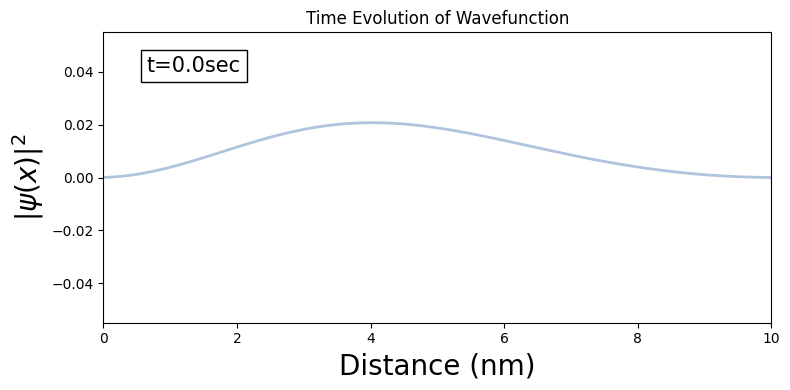

In [3]:
def animate(i):
    ln1.set_data(x, np.absolute(psi_m1[100*i])**2)
    #ln2.set_data(x, V[100*i])
    time_text.set_text('t='+'{:.1f}'.format(100*i*dt*1e4)+'sec')

fig, ax = plt.subplots(1,1, figsize=(8,4))
#ax.grid()
ln1, = plt.plot([], [], 'lightsteelblue', lw=2, markersize=8, label='Method 1')
#ln2, = plt.plot([], [], 'lightsteelblue', lw=3, markersize=8, label='Method 2')
time_text = ax.text(0.65, 0.04, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_xlim(0,10)
#ax.set_ylim(-0.01,0.04)
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('Distance (nm)', fontsize=20)
#ax.legend(loc='upper left')
ax.set_title('Time Evolution of Wavefunction')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('pen.gif',writer='pillow',fps=50,dpi=100)
#I think the beginning of the animation is chaotic due to numerical artifacts from intializing the animation by solving the finite difference equation using matrix methods before
#switching to iterative methods